# Classification accuracy of 1-split increased by 2.5%, 4-split by 4.4%. Now they differ only by 1.5%

In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
#         self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_pred = self.decode(z ,training=training)
        y_pred = self.classify(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * n_filters[0]),  # factor 4 due to conv.
            Reshape((io_shape[0]//4, io_shape[1]//4, n_filters[0])),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(10, activation='softmax')
        ])


1-split: load encoder weights and train classifier

In [2]:
import keras
import numpy as np

n_splits = 1
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)
model.encoder.load_weights('../weights/22_CE16_epoch50.h5')
for layer in model.encoder.layers:
    layer.trainable = False

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

Epoch 1/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4901 - acc: 0.8527 - val_loss: 0.1880 - val_acc: 0.9438
Epoch 2/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1795 - acc: 0.9464 - val_loss: 0.1576 - val_acc: 0.9532
Epoch 3/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1559 - acc: 0.9522 - val_loss: 0.1455 - val_acc: 0.9576
Epoch 4/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1413 - acc: 0.9566 - val_loss: 0.1321 - val_acc: 0.9605
Epoch 5/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1311 - acc: 0.9599 - val_loss: 0.1237 - val_acc: 0.9624
Epoch 6/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1233 - acc: 0.9621 - val_loss: 0.1178 - val_acc: 0.9645
Epoch 7/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1173 - acc: 0.9642 - val_loss: 0.1139 - val_acc: 0.9665
Epoch 8/25
1875/1875 [==============================] - 2s 1ms

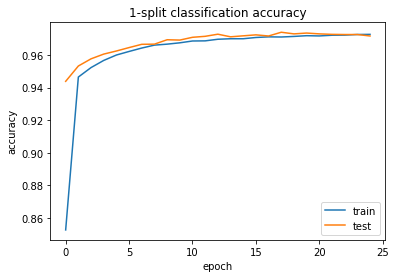

<Figure size 432x288 with 0 Axes>

In [3]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=25, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('1-split classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.savefig('../img/24/CE16_epoch25.png')

In [4]:
preds_1 = model.predict(x_test_split)  # save predictions

4-split: load encoder weights and train classifier

In [5]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)
model.encoder.load_weights('../weights/22_CE4x4_epoch50.h5')
for layer in model.encoder.layers:
    layer.trainable = False

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

Epoch 1/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5919 - acc: 0.8278 - val_loss: 0.2968 - val_acc: 0.9146
Epoch 2/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2771 - acc: 0.9164 - val_loss: 0.2464 - val_acc: 0.9279
Epoch 3/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2393 - acc: 0.9269 - val_loss: 0.2231 - val_acc: 0.9342
Epoch 4/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2170 - acc: 0.9337 - val_loss: 0.2083 - val_acc: 0.9365
Epoch 5/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2018 - acc: 0.9371 - val_loss: 0.1924 - val_acc: 0.9431
Epoch 6/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1914 - acc: 0.9401 - val_loss: 0.1834 - val_acc: 0.9454
Epoch 7/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1832 - acc: 0.9428 - val_loss: 0.1782 - val_acc: 0.9479
Epoch 8/25
1875/1875 [==============================] - 3s 1ms

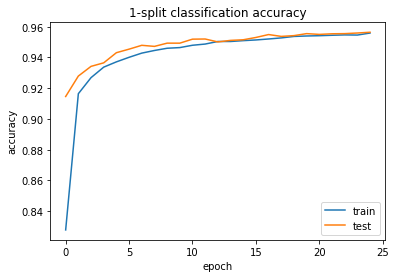

<Figure size 432x288 with 0 Axes>

In [6]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=25, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('1-split classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.savefig('../img/24/CE4x4_epoch25.png')

In [7]:
preds_2 = model.predict(x_test_split)  # save predictions

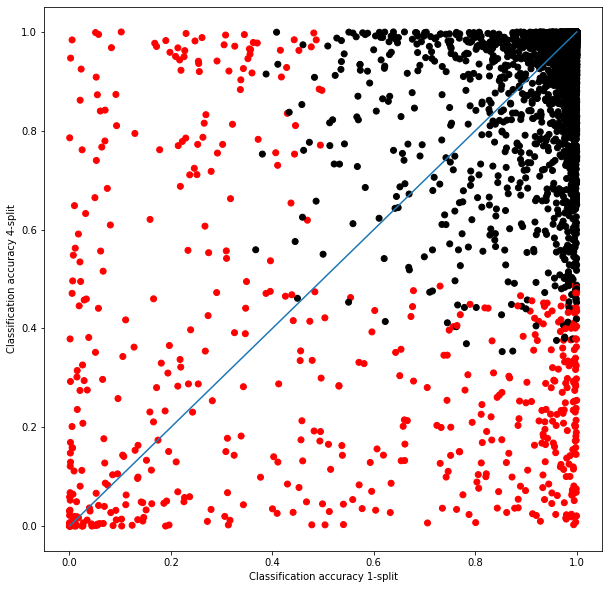

In [8]:
ps1 = [p[np.argmax(y)] for p, y in zip(preds_1, y_test)]
ps2 = [p[np.argmax(y)] for p, y in zip(preds_2, y_test)]
plt.figure(figsize=(10,10))

cols = ['black' if (np.argmax(p1) == np.argmax(y) and np.argmax(p2) ==np.argmax(y)) else 'red' for p1, p2, y in zip(preds_1, preds_2, y_test)]

plt.scatter(ps1, ps2, c=cols)
x = np.linspace(0,1,10)
plt.plot(x, x)
plt.xlabel('Classification accuracy 1-split')
plt.ylabel('Classification accuracy 4-split')
plt.savefig('../img/24/acc_scatter.png')